### Stock Market Prediction And Forecasting Using Stacked LSTM

In [2]:
!pip install pandas numpy yfinance statsmodels scikit-learn keras matplotlib alpha-vantage vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.3 MB/s eta 0:00:00


In [3]:
# **************** IMPORT PACKAGES ********************
import yfinance as yf
import requests
import csv
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import os
import math
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from alpha_vantage.timeseries import TimeSeries
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA

In [4]:
def download_stock_data(ticker):
    """Downloads historical stock data from Yahoo Finance and saves it to a CSV file.

    Args:
        ticker: The stock ticker symbol (e.g., 'AAPL').
    """
    try:
        # Download data using yfinance
        end = datetime.now()
        start = datetime(end.year - 4, end.month, end.day)
        data = yf.download(ticker, start=start, end=end)
        # Save data to CSV file
        data.to_csv(f'{ticker}.csv')
        print(f"\nData for {ticker} downloaded and saved to {ticker}.csv")
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")

# Example usage
ticker = "HDFCBANK.NS"  # Replace with your desired ticker symbol

download_stock_data(ticker)

[*********************100%***********************]  1 of 1 completed



Data for HDFCBANK.NS downloaded and saved to HDFCBANK.NS.csv


In [5]:
import pandas as pd

# Load the CSV data into a pandas DataFrame
df = pd.read_csv('HDFCBANK.NS.csv')
df.columns=["Date","Adj Close","Close","High","Low","Open","volume"]
df.drop(0,axis=0,inplace=True)
df.drop(1,axis=0,inplace=True)
df.to_csv('HDFCBANK.NS.csv', index=False)

In [6]:
df=pd.read_csv('HDFCBANK.NS.csv')

In [ ]:
# Ensure date is parsed correctly
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Feature columns and target
features = ["Adj Close", "Close", "High", "Low", "Open", "volume"]
target = "Close"

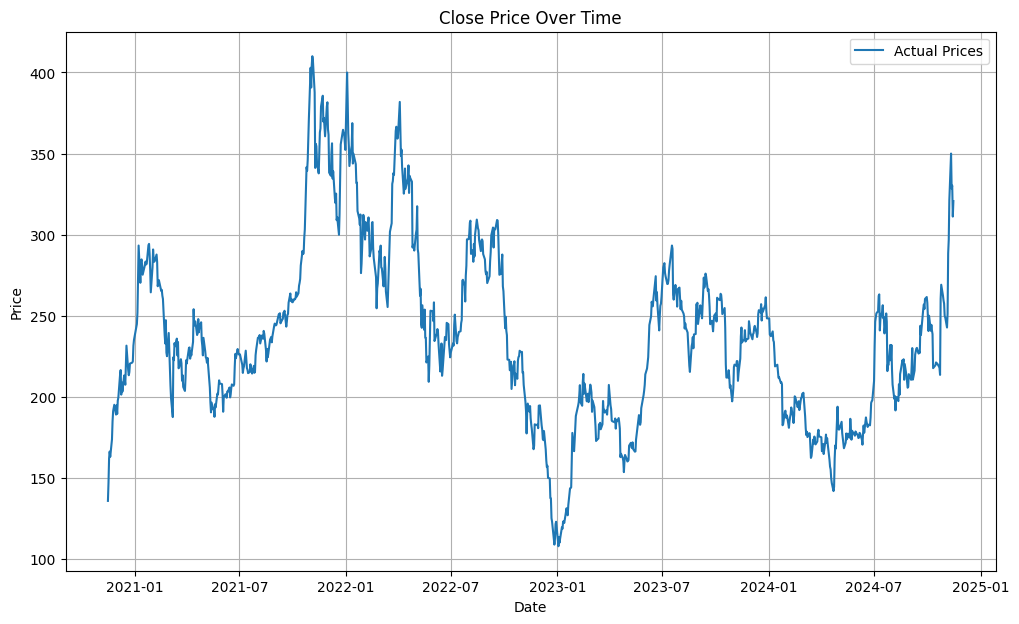

In [ ]:
# Plot 'Close' against 'Date' (the index)

# Customize the plot
plt.figure(figsize=(12, 7))
plt.plot(df['Date'], df['Close'], label='Actual Prices')

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Close Price Over Time")
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

In [ ]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler

# Normalize the data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df[features])

In [ ]:
sequence_length = 50  # Use 100 days of history to predict the next day
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, features.index(target)])

X, y = np.array(X), np.array(y)

In [ ]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.65)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))  # First LSTM layer
model.add(LSTM(50, return_sequences=True))  # Second LSTM layer
model.add(LSTM(50))  # Third LSTM layer
model.add(Dense(1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')

# from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
# from tensorflow.keras.regularizers import l1, l2

# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),
#                kernel_regularizer=l2(0.01)))  # L2 regularization on kernel weights
# model.add(LSTM(50, return_sequences=True, recurrent_regularizer=l1(0.01)))  # L1 regularization on recurrent weights
# model.add(LSTM(50))
# model.add(Dense(1))

# model.compile(optimizer='adam', loss='mean_squared_error')

# model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.2))  # Dropout with a rate of 0.2
# model.add(LSTM(50, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 50, 50)              │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 50, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,851 (202.54 KB)

 Trainable params: 51,851 (202.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - loss: 0.1083 - val_loss: 0.0056
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0122 - val_loss: 0.0056
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0074 - val_loss: 0.0058
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0064 - val_loss: 0.0052
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0059 - val_loss: 0.0041
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0051 - val_loss: 0.0038
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0059 - val_loss: 0.0034
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0048 - val_loss: 0.0033
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/st

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.03227097706631648

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

0.030260256642962557

In [ ]:
# Predict future prices
future_prices = []
last_sequence = scaled_data[-sequence_length:]

for _ in range(30):  # Predict for 30 days
    prediction = model.predict(last_sequence[np.newaxis, :, :])
    future_prices.append(prediction[0, 0])

    # Update the sequence with the predicted value
    last_sequence = np.vstack([last_sequence[1:], np.append(prediction, [0, 0, 0, 0, 0])])

# Rescale the predictions back to the original scale
future_prices = scaler.inverse_transform([[p, 0, 0, 0, 0, 0] for p in future_prices])[:, 0]

# Generate future dates
last_date = df['Date'].iloc[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, 31)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

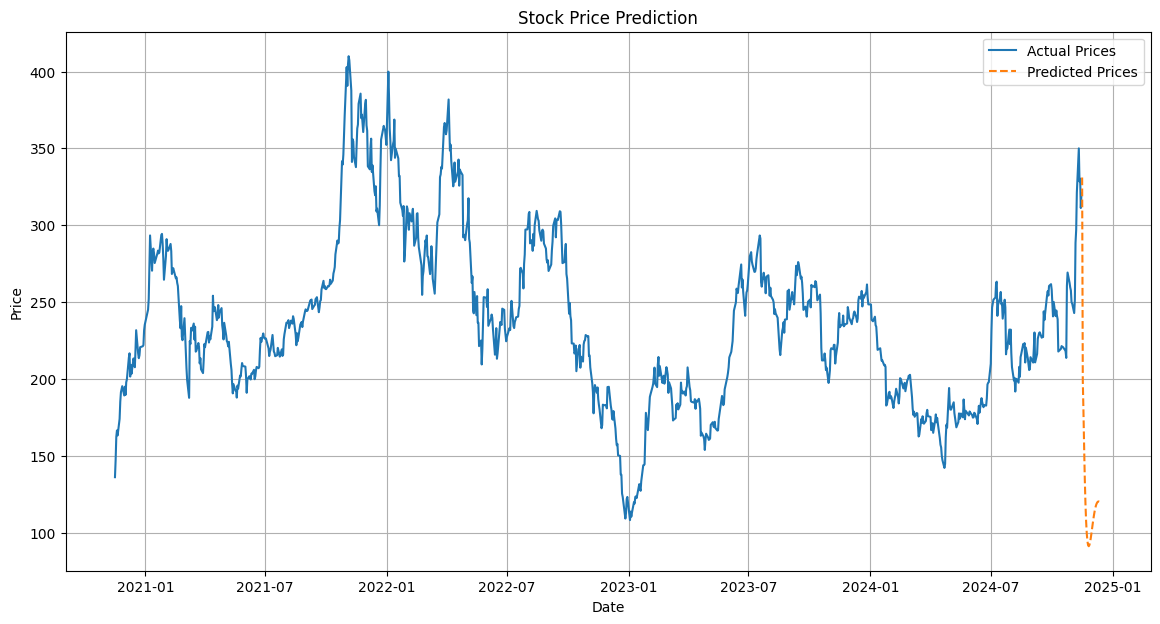

In [ ]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Actual Prices')
# plt.plot(df['Date'], train_predict, label='Predicted Prices', linestyle='oo')
plt.plot(future_dates, future_prices, label='Predicted Prices', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Output future predictions
for date, price in zip(future_dates, future_prices):
    print(f"{date.date()}: {price:.2f}")

2024-11-16: 331.04
2024-11-17: 198.83
2024-11-18: 178.69
2024-11-19: 156.02
2024-11-20: 135.13
2024-11-21: 119.06
2024-11-22: 107.35
2024-11-23: 99.33
2024-11-24: 94.33
2024-11-25: 91.76
2024-11-26: 91.09
2024-11-27: 91.87
2024-11-28: 93.72
2024-11-29: 96.29
2024-11-30: 99.31
2024-12-01: 102.54
2024-12-02: 105.77
2024-12-03: 108.86
2024-12-04: 111.67
2024-12-05: 114.12
2024-12-06: 116.16
2024-12-07: 117.76
2024-12-08: 118.94
2024-12-09: 119.71
2024-12-10: 120.13
2024-12-11: 120.24
2024-12-12: 120.10
2024-12-13: 119.78
2024-12-14: 119.33
2024-12-15: 118.80


In [16]:
def LSTM_ALGO(df, forecast_days=7):
    """LSTM to predict stock prices for the next 7 days."""
    scaler = MinMaxScaler()

    # Extract the 'Close' column for training and testing
    data = df[['Close']].values  # Ensure data is a 2D array
    train_data = data[:int(0.8 * len(data))]
    test_data = data[int(0.8 * len(data)):]

    # Scale the training data
    train_scaled = scaler.fit_transform(train_data)

    # Prepare the training dataset
    X_train, y_train = [], []
    for i in range(7, len(train_scaled)):
        X_train.append(train_scaled[i-7:i, 0])  # Last 7 days as input
        y_train.append(train_scaled[i, 0])      # Current day as label

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Reshape input to be 3D [samples, timesteps, features] for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.1))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(50))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

    # Prepare the input for prediction (last 7 days of data)
    inputs = data[-(7 + forecast_days):]  # Last 7 + forecast days data
    inputs = scaler.transform(inputs)

    # Create the test dataset for prediction
    X_test = []
    for i in range(7, len(inputs)):
        X_test.append(inputs[i-7:i, 0])

    X_test = np.array(X_test).reshape((len(X_test), 7, 1))  # Reshape for LSTM

    # Make predictions
    predicted_prices = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)


    # Convert the last index to a datetime object if it's not already
    last_date = df.index[-1]
    if not isinstance(last_date, pd.Timestamp):  # Check if it's not a Timestamp
        last_date = pd.to_datetime(last_date)  # Convert to Timestamp if needed

    # Generate future dates for the predictions
    future_dates = [(last_date + timedelta(days=i + 1)) for i in range(forecast_days)]
    future_dates = pd.DatetimeIndex(future_dates)
    # Print and visualize the predictions
    for date, price in zip(future_dates, predicted_prices.flatten()):
        print(f"LSTM Prediction - Date: {date.date()} | Predicted Price: {price:.2f}")

    plt.figure(figsize=(10, 5))
    plt.plot(df['Date'], df['Close'], label='Actual Prices')
    plt.plot(future_dates, predicted_prices, marker='o', linestyle='--', label='LSTM Forecast')
    plt.title('LSTM: 7-Day Stock Price Forecast')
    plt.legend()
    plt.show()

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2058
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0217
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0136
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0127
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0121
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0114
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0109
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0109
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0104
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0094
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0099
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0097
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0121
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0105
Epoch 15/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0093
Epoch 16/50
25/

TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x7ef152e51ed0>.

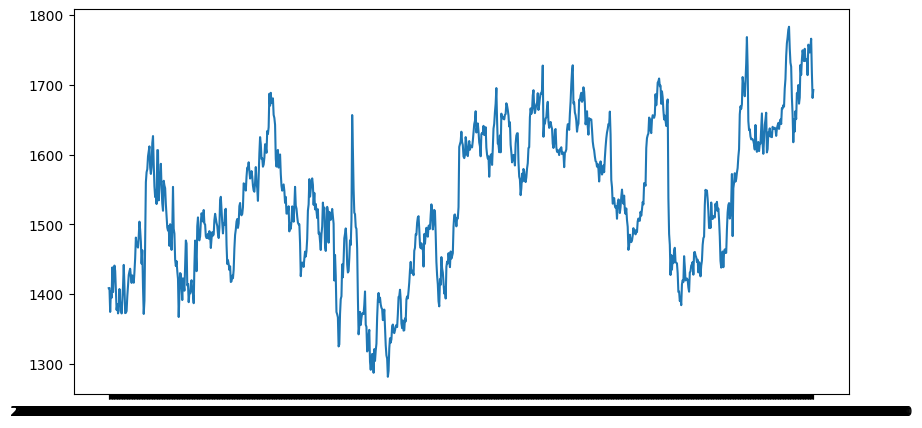

In [17]:
LSTM_ALGO(df)